## This notebook walks through the basics of generating synthetic choice data and fitting the model to that data to recover the paramaters that generated it

Fitting these models to data to choice data alone can be computational expensive. We fit the model below using 44 cpus.

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `PulseInputDDM` parallelizes the computation of the log-likelhood across trials.

In [1]:
using Distributed
addprocs(28);

### Fitting a choice model.

when `using` is called after workers have been made, i.e. above, then those modules are available on all the workers (i.e. any function called from those modules will be able to be executed on any worker)

In [2]:
using PulseInputDDM, Flatten

### Generate some data

Create an instance of the `θchoice` [composite type](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) which contains the 9 parameters of a choice DDM model. 

In [3]:
using PyPlot

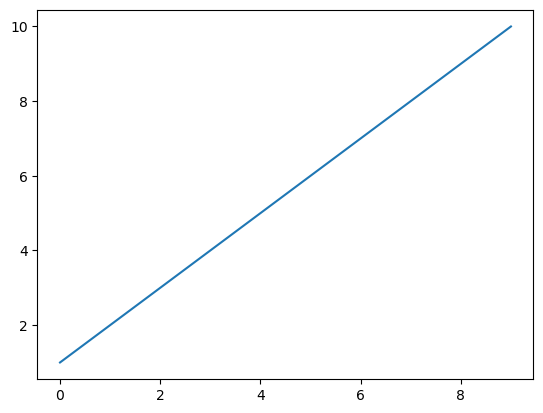

In [4]:
plot(1:10)
display(gcf())

In [5]:
θ_syn = θchoice(θz=θz(σ2_i = 1., B = 13., λ = -0.5, σ2_a = 10., σ2_s = 1.0,
    ϕ = 0.4, τ_ϕ = 0.02), bias=0.1, lapse=0.1);

In [6]:
xgen = collect(Flatten.flatten(θ_syn));

Generate 20K trials of the synthetic data using those parameters. change `rng` to get a different set with the same parameters. `dt` specifies the temporal binning of the data. `1e-2` has worked well.

In [7]:
_, data = synthetic_data(;θ=θ_syn, ntrials=8_000, rng=2, dt=1e-2);

`PulseInputDDM` computes the log-likelihood by propogating mass of the latent distribution in time. This is done numerically by dividing the distribution up into little temporal and spatial bins. `n` is the number of spatials bins to use. `n=53` seems to work well.

In [10]:
n = 53

53

Create an instance of the `choiceDDM` composite type which contains the parameters and the data of a choice DDM model. 

In [11]:
model = choiceDDM(θ=θ_syn, data=data, n=n);

to see the docstring for `choiceDDM` type `?`

In [12]:
@doc choiceDDM

```
choiceDDM(θ, data, n, cross)
```

Fields:

  * `θ`: a instance of the module-defined class `θchoice` that contains all of the model parameters for a `choiceDDM`
  * `data`: an `array` where each entry is the module-defined class `choicedata`, which contains all of the data (inputs and choices).
  * `n`: number of spatial bins to use (defaults to 53).
  * `cross`: whether or not to use cross click adaptation (defaults to false).

Example:

```julia
ntrials, dt, centered, n  = 1, 1e-2, false, 53
θ = θchoice()
_, data = synthetic_data(n ;θ=θ, ntrials=ntrials, rng=1, dt=dt);
choiceDDM(θ=θ, data=data, n=n)
```


Compute the loglikelihood of the model under the generative parameters

In [13]:
loglikelihood(model)

-2969.9823448565194

random initial state

In [14]:
x0 = vcat([0.1, 15., -0.1, 20., 0.5, 0.2, 0.008], [0.,0.01]);

use `Flatten.reconstruct` to place the intial state into the `θchoice()` type, with each variable going into the right place

In [15]:
θ = Flatten.reconstruct(θchoice(), x0)

θchoice{θz{Float64}, Float64}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.01


In [16]:
model = choiceDDM(θ=θ, data=data, n=n);

Compute the loglikelihood of the model under the initial parameters

In [17]:
loglikelihood(model)

-3473.4312908567326

Define bounds for each parameter for the optimization. Some of these are strict (i.e. variance > 0) and some are not (B < 100 seems reasonable, but B could of course be larger then 100.)

In [18]:
lb = [0., 2.,  -5., 0.,   0.,  0., 0.005, -5.0, 0.0]
ub = [30., 100., 5., 200., 10., 1.2,  1., 5.0, 1.0];

`fit` specifies which parameters should be learned. If they are not learned, they remain at their value from `x0`, the initial point of the optimization.

In [19]:
fit = vcat(trues(9));

Create an instance of the `choiceoptions` composite type, using `lb`, `ub`, and `fit`. `choiceoptions` specifies which parameters to fit, and the lower and upper bounds of the optimization.

In [20]:
options = choiceoptions(fit=fit, lb=lb, ub=ub)

choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 2.0, -5.0, 0.0, 0.0, 0.0, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 100.0, 5.0, 200.0, 10.0, 1.2, 1.0, 5.0, 1.0]


In [21]:
@doc choiceoptions

```
choiceoptions(fit, lb, ub)
```

Fields:

  * `fit`: `array` of `Bool` for optimization for `choiceDDM` model.
  * `lb`: `array` of lower bounds for optimization for `choiceDDM` model.
  * `ub`: `array` of upper bounds for optimization for `choiceDDM` model.


Define bounds for each parameter for the optimization. Some of these are strict (i.e. variance > 0) and some are not (B < 100 seems reasonable, but B could of course be larger then 100.)

### Optimize the model, using the options to define details of the optimization

In [22]:
@doc PulseInputDDM.optimize

```
optimize(x, ll, lb, ub)
```

Wrapper for executing an constrained optimization.

Arguments:

  * `ll`: objective function.
  * `x`: an `array` of initial point
  * `lb`: lower bounds. `array` the same length as `x`.
  * `ub: upper bounds.`array`the same length as`x`.

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

```
optimize(data, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `data`: an `array`, each element of which is a module-defined type `choicedata`. `choicedata` contains the click data and the choice for a trial.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM_dx`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM_dx`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

```
optimize(data, f)
```

Optimize model parameters for a `neuralDDM`. Neural tuning parameters ([`θy`](@ref)) are initialized by fitting a the noiseless DDM model first ([`noiseless_neuralDDM`](@ref)).

Arguments:

  * `data`: the output of [`load_neural_data`](@ref) with the format as described in its docstring.
  * `f`: an `array` of length number of sessions, where each subarray is length number of cells. Each entry is a string, either `Softplus` or `Sigmoid` to describe the nonlinear map between $a(t)$ and $\lambda(a)$, the expected firing rate.

Returns

  * `model`: a module-defined type that organizes the `data` and parameters from the fit (as well as a few other things that are necessary for re-computing things the way they were computed here (e.g. `n`)
  * `options`: some details related to the optimzation, such as which parameters were fit, and the upper and lower bounds of those parameters.

```
optimize(model, options)
```

Optimize model parameters for a `neuralDDM`.

Arguments: 

  * `model`: an instance of a `neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

```
optimize(model, options)
```

Optimize model parameters for a `noiseless_neuralDDM`.

Arguments: 

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

```
optimize(model, options)
```

Optimize model parameters for a `neural_choice_GLM_DDM`.

Arguments: 

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `output`: results from [`Optim.optimize`](@ref).


In [23]:
model, output = optimize(model, options, f_tol=1e-6, iterations = 100, extended_trace=true, show_trace=true)

Fminbox
-------
Initial mu = 0.160987

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.160987

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.481363e+03     5.400220e+04
 * Current step size: 1.0
 * time: 0.01902294158935547
 * g(x): [-23.743724932870556, -11.064054277817245, 24.107336545875043, -13.40926923736473, -667.8315427815991, 504.5657745923168, -54002.20187941485, -29.713291845762505, -17891.119702011667]
 * ~inv(H): [1.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.0 -0.0 1.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.0 0.0 -0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 -0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 -0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 -0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [0.1, 15.0, -0.1, 20.0, 0.5, 0.2, 0.008, 0.0, 0.01]
    10     2.976424e+03     1.878303e+03
 * Current step size: 0.4777798123749767


(choiceDDM{θchoice{θz{Float64}, Float64}, Vector{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks, PulseInputDDM.binned_clicks}}}, θprior{Float64}}
  θ: θchoice{θz{Float64}, Float64}
  data: Array{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks, PulseInputDDM.binned_clicks}}}((8000,))
  n: Int64 53
  cross: Bool false
  θprior: θprior{Float64}
,  * Status: success

 * Candidate solution
    Final objective value:     2.972898e+03

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 3.24e-04 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.16e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-06
    |g(x)|                 = 5.57e-01 ≰ 1.0e-03

 * Work counters
    Seconds run:   1151  (vs limit 170000)
    Iterations:    3
    f(x) calls:    57
    ∇f(x) calls:   37
)

Compute the likelihood of the optimized model

In [24]:
loglikelihood(model)

-2962.9948315150286

Compute the gradient of the model after optimization, to ensure we are near the minimum of the loglikelihood

In [25]:
gradient(model)

9-element Vector{Float64}:
 -0.02148992706662494
 -0.020803739164585444
  0.02371277840733299
  0.0005516139016776347
 -0.01726935764427351
  0.9444722061929269
  0.8663104692649597
 -0.01667068230402946
  1.9574639050152882

Compute the Hessian of the model, to compute confidence bounds around the ML parameters

In [26]:
H = Hessian(model)
CI, HPSD = CIs(H);

Check the eigenvalues of the hessian, to ensure that it is positive semidefinite

In [27]:
using LinearAlgebra
eigvals(H)

9-element Vector{Float64}:
      0.0007159995090610957
      0.002661706557559838
      0.030860087406699873
      7.394942813320598
     16.35774444661152
     43.482947098080984
     67.95701216855164
  15769.334315161805
 659890.5291036979

In [28]:
xf = collect(Flatten.flatten(model.θ));

Check that the solution is within the confidence intervals

In [29]:
(xf - CI) .< xgen, (xf + CI) .> xgen

(Bool[1, 1, 1, 1, 1, 1, 1, 1, 1], Bool[1, 1, 1, 1, 1, 1, 1, 1, 0])

In [30]:
output

 * Status: success

 * Candidate solution
    Final objective value:     2.972898e+03

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 3.24e-04 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.16e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-06
    |g(x)|                 = 5.57e-01 ≰ 1.0e-03

 * Work counters
    Seconds run:   1151  (vs limit 170000)
    Iterations:    3
    f(x) calls:    57
    ∇f(x) calls:   37


Get the step-by-step values of the optimization and plot them

In [31]:
trace = hcat(map(x-> x.metadata["x"], output.trace)...);

In [32]:
using PyPlot

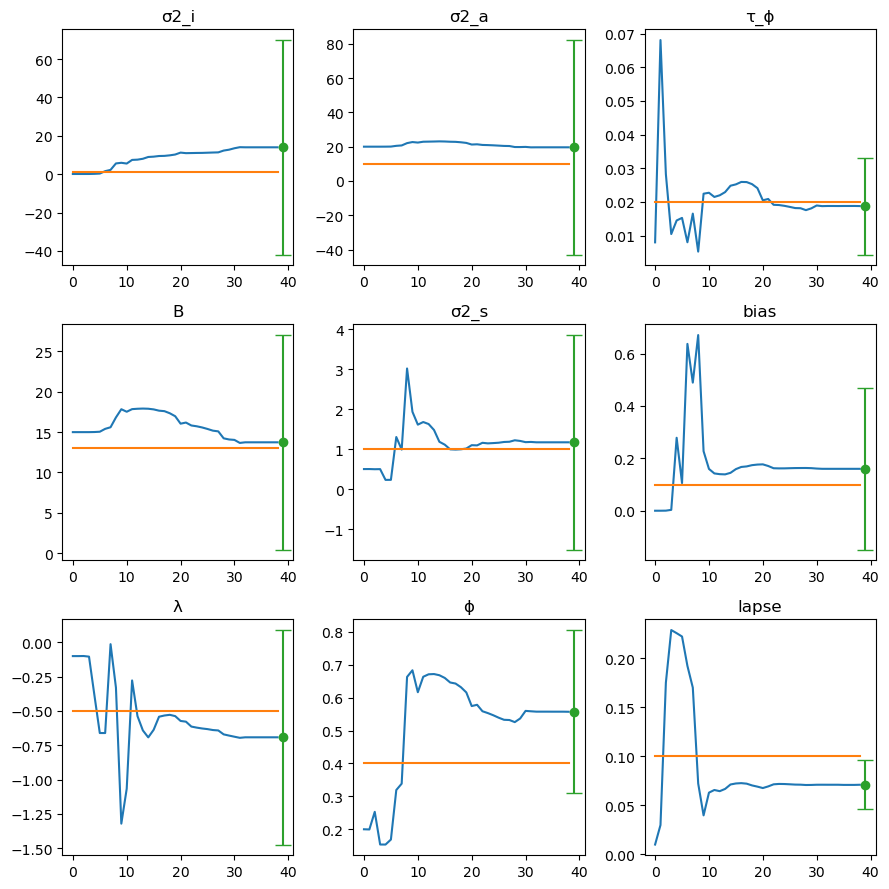

In [33]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(trace[i,:])
    ax[i].plot(xgen[i] * ones(size(trace,2)))
    ax[i].set_title(name[i])
    
    ax[i].errorbar(size(trace, 2), xf[i], yerr=CI[i], fmt="o",
        capsize=6)
end

tight_layout() 
display(gcf())

In [34]:
lb = options.lb
ub = options.ub;

Compute the LL over the optimization domain, for plotting

In [35]:
@everywhere ℓℓ(x, model) = -PulseInputDDM.loglikelihood(x, model)

In [36]:
αs = hcat(map((lb,ub)-> range(lb + eps(), stop=ub, length=30), lb, ub));

In [37]:
LL_scan = map(i-> map(x-> ℓℓ(vcat(xf[1:i-1], x, xf[i+1:end]), model), αs[i]), 1:9);

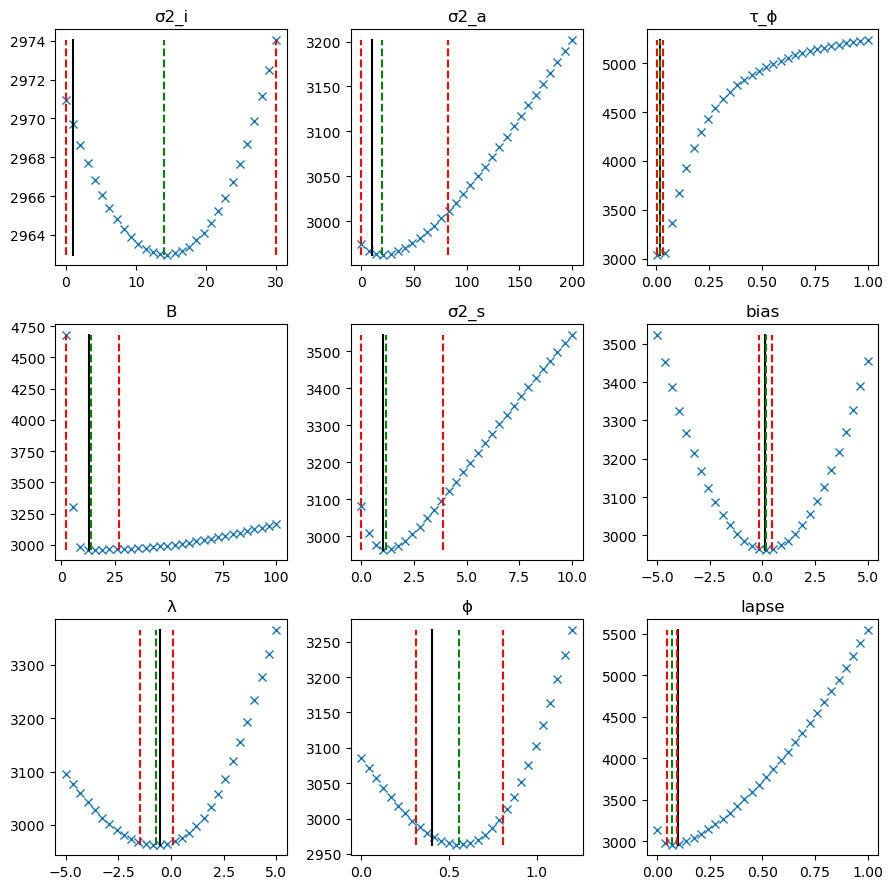

In [39]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(xgen[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100), "k")
    ax[i].plot(xf[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100),
        "g--")
    ax[i].plot(max((xf[i] - CI[i]), lb[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")
    ax[i].plot(min((xf[i] + CI[i]), ub[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")

    
end

tight_layout() 
display(gcf())

## Saving and reloading modeling results and saving data

Use the `save_choice_model` function to save the optimized model, the options used to define the optimization, and the confidence intervals

In [40]:
save_file = "../choice model/example_results.mat"
save_choice_model(save_file, model, options, CI)

if you want to restart the optimization from where you stopped `reload_choice_model` will reload those model parameters and the `options`

In [41]:
θ, options = reload_choice_model(save_file);

Save the choice data using `save_choice_data` and then reload it using `load_choice_data`

In [42]:
import PulseInputDDM: save_choice_data

In [43]:
save_choice_data("../choice model/example_matfile_2.mat", data)

In [44]:
data = load_choice_data("../choice model/example_matfile_2.mat");

In [45]:
model = choiceDDM(θ=θ, data=data, n=n);
loglikelihood(model)

-2962.9948315150286

## Loading data and fitting a choice model from real data

Because many neuroscientists use matlab, we use the [MAT.jl](https://github.com/JuliaIO/MAT.jl) package for IO. Data can be loaded using two conventions. One of these conventions is easier when data is saved within matlab as a .MAT file, and is described below. 

The package expects your data to live in a single .mat file which should contain a struct called `rawdata`. Each element of `rawdata` should have data for one behavioral trial and `rawdata` should contain the following fields with the specified structure:

 - `rawdata.leftbups`: row-vector containing the relative timing, in seconds, of left clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.rightbups`: row-vector containing the relative timing in seconds (origin at 0 sec) of right clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.T`: the duration of the trial, in seconds. The beginning of a trial is defined as the start of the click stimulus. The end of a trial is defined based on the behavioral event “cpoke_end”. This was the Hanks convention.
 - `rawdata.pokedR`: `Bool` representing the animal choice (1 = right).
 
The example file located at `../choice model/example_matfile.mat` adheres to this convention and can be loaded using the `load_choice_data` method.

In [46]:
data = load_choice_data("../choice model/example_matfile.mat");

In [47]:
θ2 = θchoice(θz=θz(σ2_i = 2., B = 23., λ = 0.5, σ2_a = 100., σ2_s = 1.1,
    ϕ = 0.35, τ_ϕ = 0.035), bias=0.2, lapse=0.01);

In [48]:
model = choiceDDM(θ=θ2, data=data, n=n);
loglikelihood(model)

-4.321480367653434